In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

from sklearn.preprocessing import RobustScaler, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb

sns.set(rc={"figure.figsize":(12, 12)})

In [2]:
def imputinator(df:'pandas.DataFrame')->'pandas.DataFrame':
  
    for col in ['PoolQC', 'MiscFeature', 'Alley', 'FireplaceQu', 'GarageCond', 
              'GarageType', 'GarageFinish', 'GarageQual', 'BsmtExposure', 
              'BsmtFinType1', 'BsmtFinType2', 'BsmtCond', 'BsmtQual', 
              'MasVnrType','Fence']:
              
              df[col].fillna('None', inplace=True)
  
    for col in ['Electrical', 'LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'MSZoning',
              'Functional', 'BsmtFullBath', 'BsmtHalfBath', 'Utilities', 'KitchenQual',
              'BsmtFinSF1', 'Exterior2nd', 'GarageCars', 'GarageArea', 'BsmtFinSF2',
              'SaleType', 'TotalBsmtSF', 'BsmtUnfSF', 'Exterior1st']:
              
              df[col].fillna(df[col].mode()[0], inplace=True)
    return df


def rmse(pred:'numpy.array', truth:'numpy.array')->'float':
    return np.sqrt(mean_squared_error(pred, truth))

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train_id = train['Id']
train.drop(columns=['Id'])

train_nrows = train.shape[0]
test_nrows = test.shape[0]

In [4]:
df_concat = pd.concat([train, test]).reset_index(drop=True)

sale_concat = df_concat['SalePrice']

df_concat.drop(columns=['SalePrice', 'Id'], inplace=True)
df_concat.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [5]:
missing_values_count = df_concat.isna().sum().sort_values(ascending=False)
missing_values = missing_values_count[missing_values_count > 0]

missing_values

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
BsmtUnfSF          1
TotalBsmtSF        1
Exterior1st        1
SaleType           1
Electrical         1
KitchenQual        1
GarageArea         1
GarageCars         1
dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 [Text(0, 0, 'PoolQC'),
  Text(1, 0, 'MiscFeature'),
  Text(2, 0, 'Alley'),
  Text(3, 0, 'Fence'),
  Text(4, 0, 'FireplaceQu'),
  Text(5, 0, 'LotFrontage'),
  Text(6, 0, 'GarageCond'),
  Text(7, 0, 'GarageQual'),
  Text(8, 0, 'GarageYrBlt'),
  Text(9, 0, 'GarageFinish'),
  Text(10, 0, 'GarageType'),
  Text(11, 0, 'BsmtCond'),
  Text(12, 0, 'BsmtExposure'),
  Text(13, 0, 'BsmtQual'),
  Text(14, 0, 'BsmtFinType2'),
  Text(15, 0, 'BsmtFinType1'),
  Text(16, 0, 'MasVnrType'),
  Text(17, 0, 'MasVnrArea'),
  Text(18, 0, 'MSZoning'),
  Text(19, 0, 'BsmtHalfBath'),
  Text(20, 0, 'Utilities'),
  Text(21, 0, 'Functional'),
  Text(22, 0, 'BsmtFullBath'),
  Text(23, 0, 'BsmtFinSF2'),
  Text(24, 0, 'BsmtFinSF1'),
  Text(25, 0, 'Exterior2nd'),
  Text(26, 0, 'BsmtUnfSF'),
  Text(27, 0, 'TotalBsmtSF'),
  Text(28, 0, 'Exterior1st'),
  Text(29, 0, 'Sal

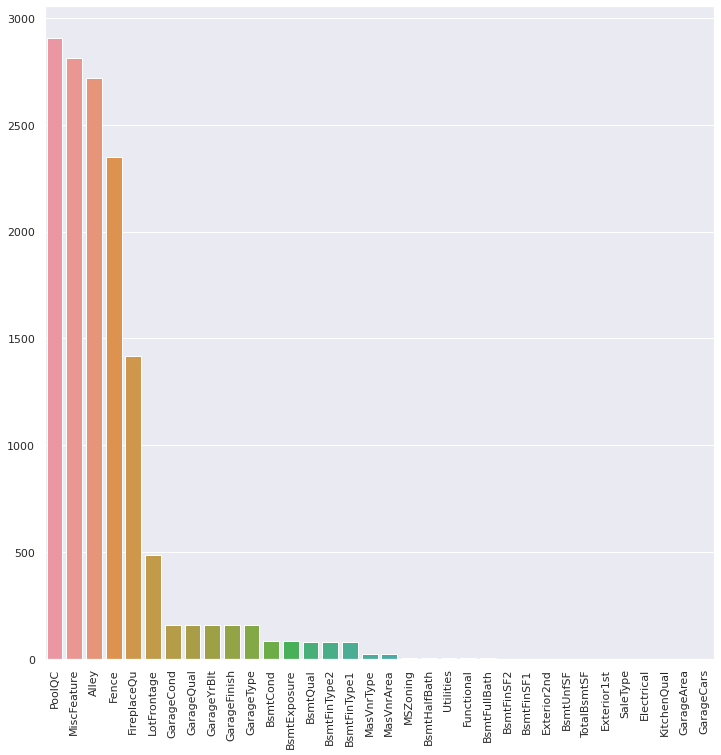

In [6]:
sns.barplot(x=missing_values.index, y=missing_values)
plt.xticks(rotation='90')

In [7]:
df_concat = imputinator(df_concat)

In [8]:
df_numerical = pd.concat([train, test]).reset_index(drop=True).select_dtypes(exclude='object')

df_numerical.corr().apply(np.abs).SalePrice.sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
Id               0.021917
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
Name: SalePr

In [9]:
df_numerical['TotalBathrooms'] = df_numerical['FullBath'] + df_numerical['BsmtFullBath'] + 0.5*(df_numerical['HalfBath'] + df_numerical['BsmtHalfBath'])
df_numerical['TotalArea'] = df_numerical['TotalBsmtSF'] + df_numerical['1stFlrSF'] + df_numerical['2ndFlrSF'] + df_numerical['GarageArea']
df_numerical['HouseAge'] = 2022 - df_numerical['YearBuilt']
df_numerical['YrSncRemod'] = 2022 - df_numerical['YearRemodAdd']

In [10]:
df_numerical.corr().apply(np.abs).SalePrice.sort_values(ascending=False)

SalePrice         1.000000
TotalArea         0.809561
OverallQual       0.790982
GrLivArea         0.708624
GarageCars        0.640409
TotalBathrooms    0.631731
GarageArea        0.623431
TotalBsmtSF       0.613581
1stFlrSF          0.605852
FullBath          0.560664
TotRmsAbvGrd      0.533723
YearBuilt         0.522897
HouseAge          0.522897
YearRemodAdd      0.507101
YrSncRemod        0.507101
GarageYrBlt       0.486362
MasVnrArea        0.477493
Fireplaces        0.466929
BsmtFinSF1        0.386420
LotFrontage       0.351799
WoodDeckSF        0.324413
2ndFlrSF          0.319334
OpenPorchSF       0.315856
HalfBath          0.284108
LotArea           0.263843
BsmtFullBath      0.227122
BsmtUnfSF         0.214479
BedroomAbvGr      0.168213
KitchenAbvGr      0.135907
EnclosedPorch     0.128578
ScreenPorch       0.111447
PoolArea          0.092404
MSSubClass        0.084284
OverallCond       0.077856
MoSold            0.046432
3SsnPorch         0.044584
YrSold            0.028923
L

The combined variables seem to have a much better correlation.

In [11]:
df_numerical.drop(columns=[
    'FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath', 'Id',
    '1stFlrSF', '2ndFlrSF', 'GarageArea', 'YearBuilt', 'YearRemodAdd'
], inplace=True)

In [12]:
df_numerical.corr().apply(np.abs).SalePrice.sort_values(ascending=False)

SalePrice         1.000000
TotalArea         0.809561
OverallQual       0.790982
GrLivArea         0.708624
GarageCars        0.640409
TotalBathrooms    0.631731
TotalBsmtSF       0.613581
TotRmsAbvGrd      0.533723
HouseAge          0.522897
YrSncRemod        0.507101
GarageYrBlt       0.486362
MasVnrArea        0.477493
Fireplaces        0.466929
BsmtFinSF1        0.386420
LotFrontage       0.351799
WoodDeckSF        0.324413
OpenPorchSF       0.315856
LotArea           0.263843
BsmtUnfSF         0.214479
BedroomAbvGr      0.168213
KitchenAbvGr      0.135907
EnclosedPorch     0.128578
ScreenPorch       0.111447
PoolArea          0.092404
MSSubClass        0.084284
OverallCond       0.077856
MoSold            0.046432
3SsnPorch         0.044584
YrSold            0.028923
LowQualFinSF      0.025606
MiscVal           0.021190
BsmtFinSF2        0.011378
Name: SalePrice, dtype: float64

Drop seemingly meaningless variables cov(<0.15)

In [13]:
mask = df_numerical.corr().apply(np.abs).SalePrice.sort_values(ascending=False) < 0.15
index_to_be_dropped = df_numerical.corr().apply(np.abs).SalePrice.sort_values(ascending=False)[mask].index

In [14]:
df_numerical.drop(columns=index_to_be_dropped, inplace=True)

<AxesSubplot:>

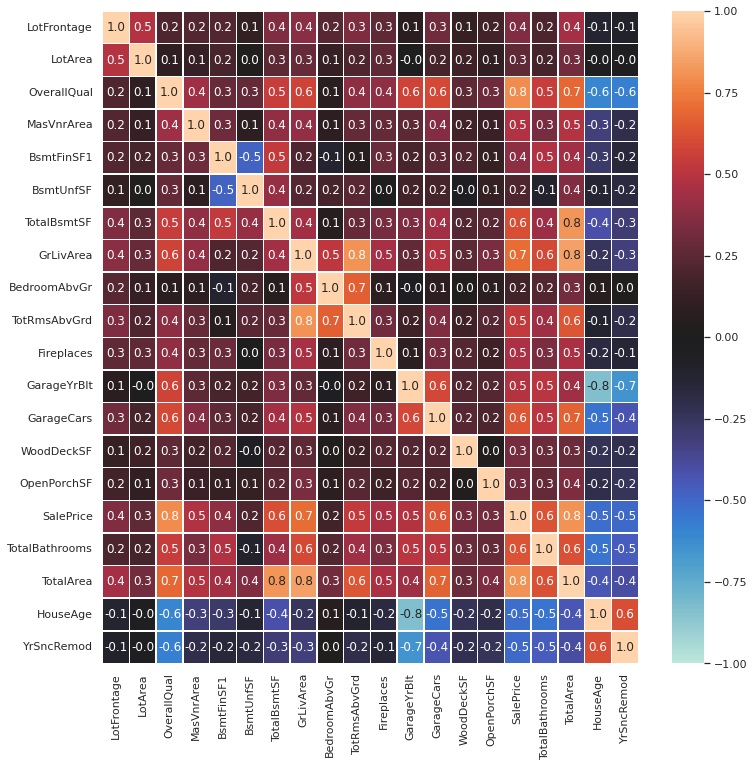

In [15]:
sns.heatmap(df_numerical.corr(), 
            vmin=-1.0, 
            vmax=1.0, 
            annot=True, 
            linewidths=0.5, 
            fmt='1.1f', 
            cmap='icefire')

Now look at covariance between dependant variable.

<AxesSubplot:>

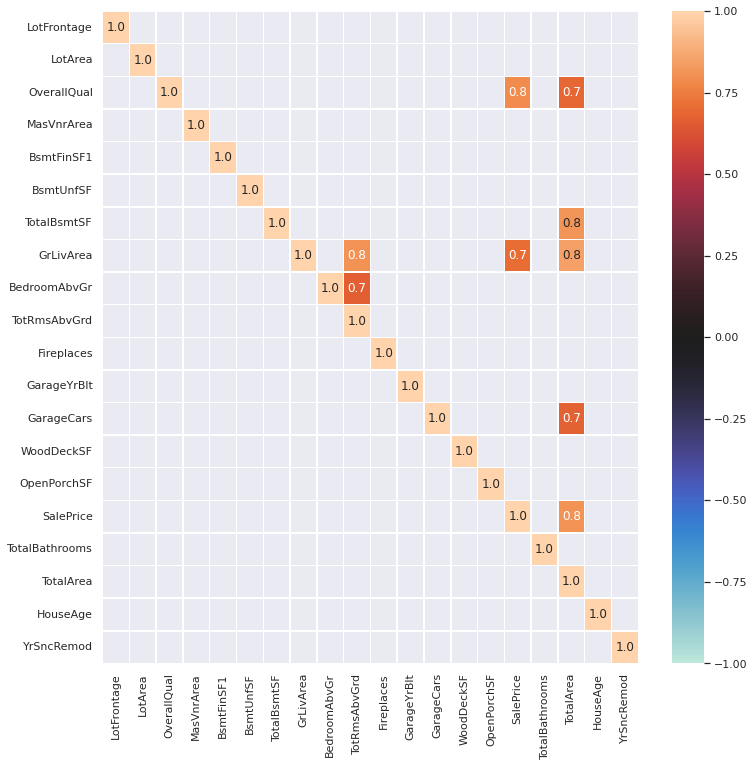

In [16]:
sns.heatmap(df_numerical.corr(), 
            vmin=-1.0, 
            vmax=1.0, 
            annot=True, 
            linewidths=0.5, 
            fmt='1.1f', 
            cmap='icefire', 
            mask=np.triu(df_numerical.apply(np.abs).corr()) < 0.65)

- `TotRmsAbvGrd`, `GrLivArea` and `BedroomAbvGr` give overlapping information. `SalePrice` is highly correlated with `GrLivArea`, `TotalArea` and `OverallQual`. We could do PCA but first let's try keeping only the most general.

- Keep: `TotalArea` and `OverallQual`
- Drop `TotRmsAbvGrd`, `GrLivArea`, `BedroomAbvGr`, and  `TotalBsmtSF`

This of course don't fix the issue of the high correlation between `OverallQual` and `TotalArea`.

In [17]:
df_numerical.drop(columns=['TotRmsAbvGrd', 'GrLivArea', 'BedroomAbvGr', 'TotalBsmtSF', 'GarageYrBlt' ,'GarageCars'], inplace=True)

<AxesSubplot:>

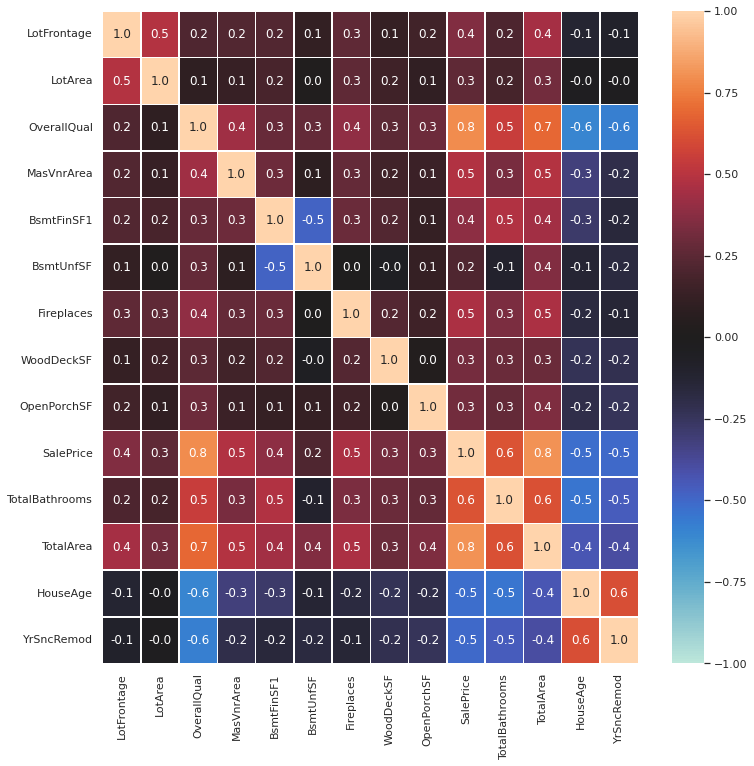

In [18]:
sns.heatmap(df_numerical.corr(), 
            vmin=-1.0, 
            vmax=1.0, 
            annot=True, 
            linewidths=0.5, 
            fmt='1.1f', 
            cmap='icefire')

Apply changes to full dataset

In [19]:
df_concat['TotalBathrooms'] = df_concat['FullBath'] + df_concat['BsmtFullBath'] + 0.5*(df_concat['HalfBath'] + df_concat['BsmtHalfBath'])
df_concat['TotalArea'] = df_concat['TotalBsmtSF'] + df_concat['1stFlrSF'] + df_concat['2ndFlrSF'] + df_concat['GarageArea']
df_concat['HouseAge'] = 2022 - df_concat['YearBuilt']
df_concat['YrSncRemod'] = 2022 - df_concat['YearRemodAdd']

df_concat.drop(columns=[
    'FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath',
    '1stFlrSF', '2ndFlrSF', 'GarageArea', 'YearBuilt', 'YearRemodAdd'
], inplace=True)

df_concat.drop(columns=index_to_be_dropped, inplace=True)

df_concat.drop(columns=['TotRmsAbvGrd', 'GrLivArea', 'BedroomAbvGr', 'TotalBsmtSF', 'GarageYrBlt' ,'GarageCars'], inplace=True)

<AxesSubplot:>

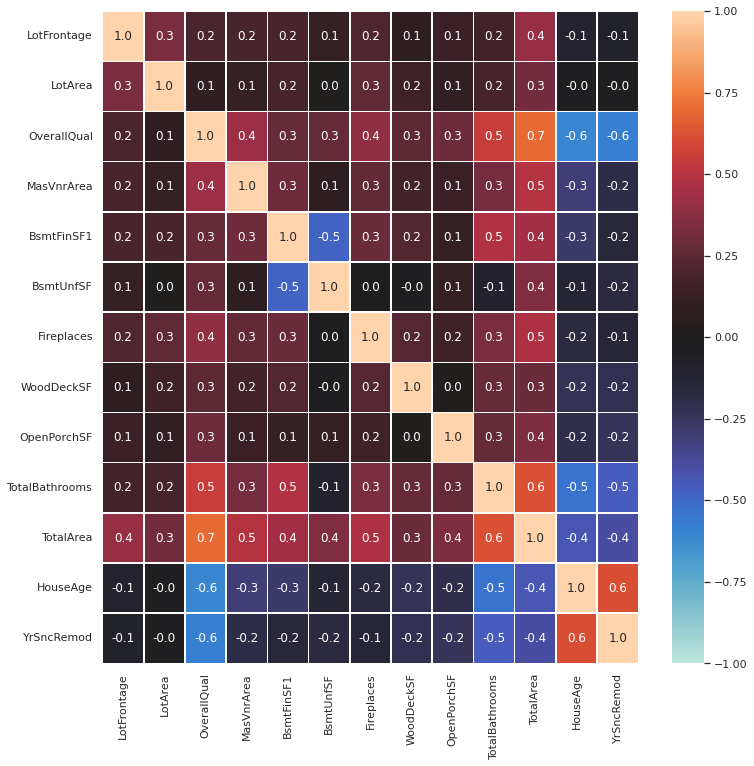

In [20]:
sns.heatmap(df_concat.corr(), 
            vmin=-1.0, 
            vmax=1.0, 
            annot=True, 
            linewidths=0.5, 
            fmt='1.1f', 
            cmap='icefire')

In [21]:
df_numerical.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtUnfSF', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice',
       'TotalBathrooms', 'TotalArea', 'HouseAge', 'YrSncRemod'],
      dtype='object')

In [22]:
df_concat.LotFrontage.apply(np.log1p)
df_concat.OverallQual = df_concat.OverallQual.apply(np.log1p)
df_concat.MasVnrArea = df_concat.MasVnrArea.apply(np.log1p)
df_concat.BsmtFinSF1 = df_concat.BsmtFinSF1.apply(np.log1p)
df_concat.BsmtUnfSF = df_concat.BsmtUnfSF.apply(np.log1p)
df_concat.WoodDeckSF = df_concat.WoodDeckSF.apply(np.log1p)
df_concat.OpenPorchSF = df_concat.OpenPorchSF.apply(np.log1p)
df_concat.HouseAge = df_concat.HouseAge.apply(np.log1p)
df_concat.YrSncRemod = df_concat.YrSncRemod.apply(np.log1p)

In [23]:
sale_concat = sale_concat.apply(np.log1p)

Next look at the non-numerical values and determine how they should be cardinalized. There will be mtwo catergories:

- Variables that need an ranked encoding - Ordinal
- Variables that need a binary encoding - OneHotTransform


In [24]:
df_concat.select_dtypes(include='object').columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [25]:
df_concat = pd.get_dummies(
    df_concat, 
    columns=[
        'MSZoning', 
        'Street',
        'Alley',
        'LotShape',
        'LandContour',
        'Utilities',
        'LotConfig',
        'LandSlope',
        'Neighborhood',
        'Condition1',
        'Condition2',
        'BldgType',
        'HouseStyle',
        'RoofStyle',
        'RoofMatl',
        'Exterior1st',
        'Exterior2nd',
        'MasVnrType',
        'Foundation',
        'Heating',
        'CentralAir',
        'Electrical',
        'PavedDrive',
        'Fence',
        'MiscFeature',
        'SaleType',
        'BsmtFinType1',
        'BsmtFinType2',
        'Functional',
        'GarageType',
        'GarageFinish'
    ]
)


In [26]:
ordinal_columns = df_concat.select_dtypes(include='object').columns

In [27]:
df_ordinal = df_concat[ordinal_columns]

In [28]:
ordinal = OrdinalEncoder()

df_ordinal = pd.DataFrame(ordinal.fit_transform(df_ordinal), columns=ordinal_columns)

In [29]:
df_ordinal

,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC,SaleCondition
0,2.0,4.0,2.0,4.0,3.0,0.0,2.0,3.0,5.0,5.0,3.0,4.0
1,3.0,4.0,2.0,4.0,1.0,0.0,3.0,5.0,5.0,5.0,3.0,4.0
2,2.0,4.0,2.0,4.0,2.0,0.0,2.0,5.0,5.0,5.0,3.0,4.0
3,3.0,4.0,4.0,1.0,3.0,2.0,2.0,2.0,5.0,5.0,3.0,0.0
4,2.0,4.0,2.0,4.0,0.0,0.0,2.0,5.0,5.0,5.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2914,3.0,4.0,4.0,4.0,3.0,2.0,3.0,3.0,3.0,3.0,3.0,4.0
2915,3.0,4.0,4.0,4.0,3.0,4.0,3.0,3.0,5.0,5.0,3.0,0.0
2916,3.0,4.0,4.0,4.0,3.0,0.0,3.0,5.0,5.0,5.0,3.0,0.0
2917,3.0,4.0,2.0,4.0,0.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0


In [30]:
df_concat.drop(columns=ordinal_columns, inplace=True)

In [31]:
df_concat = df_concat.merge(df_ordinal, how='inner', on=df_concat.index)

In [32]:
df_concat

,key_0,LotFrontage,LotArea,OverallQual,MasVnrArea,BsmtFinSF1,BsmtUnfSF,Fireplaces,WoodDeckSF,OpenPorchSF,...,BsmtQual,BsmtCond,BsmtExposure,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC,SaleCondition
0,0,65.0,8450,2.079442,5.283204,6.561031,5.017280,0,0.000000,4.127134,...,2.0,4.0,3.0,0.0,2.0,3.0,5.0,5.0,3.0,4.0
1,1,80.0,9600,1.945910,0.000000,6.886532,5.652489,1,5.700444,0.000000,...,2.0,4.0,1.0,0.0,3.0,5.0,5.0,5.0,3.0,4.0
2,2,68.0,11250,2.079442,5.093750,6.188264,6.075346,1,0.000000,3.761200,...,2.0,4.0,2.0,0.0,2.0,5.0,5.0,5.0,3.0,4.0
3,3,60.0,9550,2.079442,0.000000,5.379897,6.293419,1,0.000000,3.583519,...,4.0,1.0,3.0,2.0,2.0,2.0,5.0,5.0,3.0,0.0
4,4,84.0,14260,2.197225,5.860786,6.486161,6.196444,1,5.262690,4.442651,...,2.0,4.0,0.0,0.0,2.0,5.0,5.0,5.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2914,21.0,1936,1.609438,0.000000,0.000000,6.304449,0,0.000000,0.000000,...,4.0,4.0,3.0,2.0,3.0,3.0,3.0,3.0,3.0,4.0
2915,2915,21.0,1894,1.609438,0.000000,5.533389,5.686975,0,0.000000,3.218876,...,4.0,4.0,3.0,4.0,3.0,3.0,5.0,5.0,3.0,0.0
2916,2916,160.0,20000,1.791759,0.000000,7.110696,0.000000,1,6.163315,0.000000,...,4.0,4.0,3.0,0.0,3.0,5.0,5.0,5.0,3.0,0.0
2917,2917,62.0,10441,1.791759,0.000000,5.823046,6.356108,0,4.394449,3.496508,...,2.0,4.0,0.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0


In [33]:
scaler = RobustScaler()

df_concat = pd.DataFrame(scaler.fit_transform(df_concat), columns=df_concat.columns)

In [34]:
df_concat.drop(columns=['key_0'], inplace=True)
df_concat

,LotFrontage,LotArea,OverallQual,MasVnrArea,BsmtFinSF1,BsmtUnfSF,Fireplaces,WoodDeckSF,OpenPorchSF,TotalBathrooms,...,BsmtQual,BsmtCond,BsmtExposure,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC,SaleCondition
0,0.111111,-0.245112,0.464163,1.035332,0.098543,-0.874234,-1.0,0.000000,0.195018,1.5,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
1,0.944444,0.035924,0.000000,0.000000,0.147872,-0.383315,0.0,1.111220,-0.773184,0.5,...,0.0,0.0,-2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2,0.277778,0.439150,0.464163,0.998206,0.042050,-0.056512,0.0,0.000000,0.109172,1.5,...,0.0,0.0,-1.0,0.0,-1.0,2.0,0.0,0.0,0.0,0.0
3,-0.166667,0.023705,0.464163,0.000000,-0.080457,0.112025,0.0,0.000000,0.067489,0.0,...,1.0,-3.0,0.0,0.5,-1.0,-1.0,0.0,0.0,0.0,-4.0
4,1.166667,1.174731,0.873584,1.148519,0.087196,0.037078,0.0,1.025886,0.269036,1.5,...,0.0,0.0,-3.0,0.0,-1.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,-2.333333,-1.836999,-1.169598,0.000000,-0.895778,0.120549,-1.0,0.000000,-0.773184,-0.5,...,1.0,0.0,0.0,0.5,0.0,0.0,-2.0,-2.0,0.0,0.0
2915,-2.333333,-1.847263,-1.169598,0.000000,-0.057196,-0.356663,-1.0,0.000000,-0.018055,-0.5,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-4.0
2916,5.388889,2.577468,-0.535837,0.000000,0.181844,-4.751814,0.0,1.201450,-0.773184,0.0,...,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,-4.0
2917,-0.055556,0.241447,-0.535837,0.000000,-0.013299,0.160473,-1.0,0.856635,0.047076,-0.5,...,0.0,0.0,-3.0,1.0,0.0,0.0,-2.0,-2.0,0.0,0.0


Now we need to check the Gauss-Markov Assumptions

In [35]:
#transformer = PowerTransformer(method='yeo-johnson')

#df_concat.OverallQual = df_concat.OverallQual.transform(func = lambda x: transformer.fit_transform(x.values.reshape(-1, 1)))

In [36]:
X = df_concat[:train_nrows]
y = sale_concat[:train_nrows]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [37]:
y_results = pd.DataFrame()

In [38]:
results = {}

linear = LinearRegression()
linear.fit(X, y)

y_pred = linear.predict(X_val)
results['linear'] = rmse(y_pred, y_val)

y_results['linear'] = y_pred

In [39]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

ridge = Ridge()
param = {'alpha': [0.001, 0.1, 0.001, 10, 100]}

ridge_grid_search = GridSearchCV(estimator=ridge, 
                                 param_grid=param, 
                                 scoring='r2', 
                                 cv=kfolds, 
                                 verbose=True, 
                                 return_train_score=True)
ridge_grid_search.fit(X_train, y_train)

y_pred = ridge_grid_search.predict(X_val)

results['ridge'] = rmse(y_pred, y_val)
y_results['ridge'] = y_pred

ridge_grid_search.best_estimator_

Fitting 10 folds for each of 5 candidates, totalling 50 fits


Ridge(alpha=10)

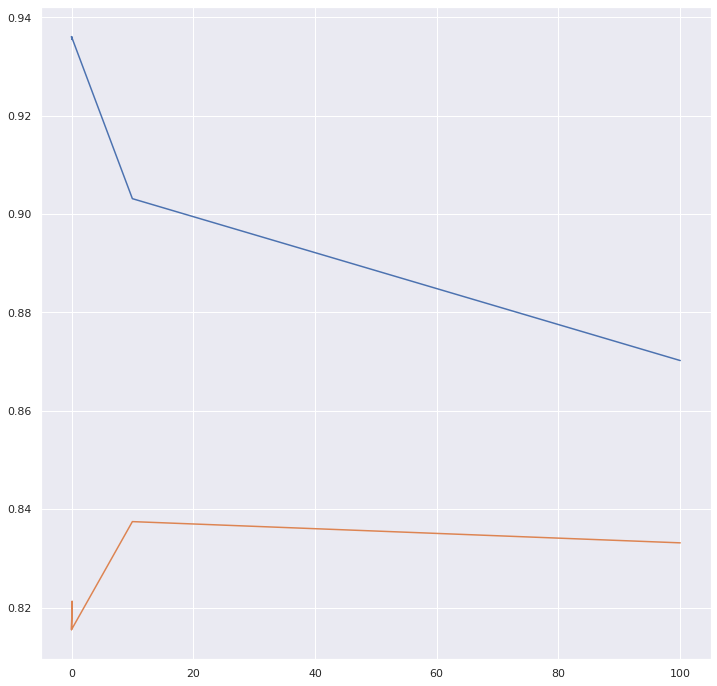

In [40]:
plt.plot(ridge_grid_search.cv_results_['param_alpha'].data,
         ridge_grid_search.cv_results_['mean_train_score'].data)

plt.plot(ridge_grid_search.cv_results_['param_alpha'].data,
         ridge_grid_search.cv_results_['mean_test_score'].data)

In [41]:
lasso = Lasso()
param = {'alpha':[0.001, 0.01, 0.03, 0.05, 0.09, 0.7, 0.9, 5, 10, 20]}

lasso_grid_search = GridSearchCV(estimator=lasso, 
                                 param_grid=param, 
                                 scoring='r2', 
                                 cv=kfolds, 
                                 verbose=True,
                                 return_train_score=True)
lasso_grid_search.fit(X_train, y_train)

y_pred = lasso_grid_search.predict(X_val)

results['lasso'] = rmse(y_pred, y_val)
y_results['lasso'] = y_pred

lasso_grid_search.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Lasso(alpha=0.001)

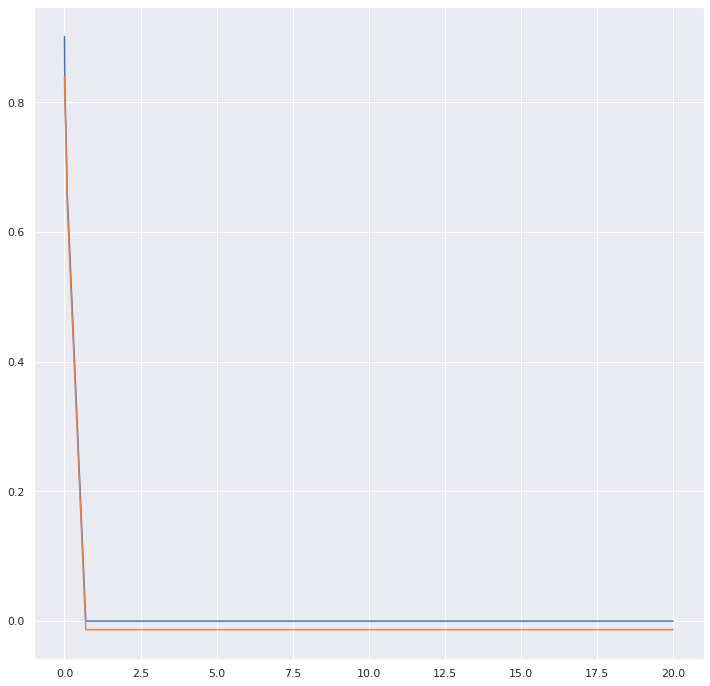

In [42]:
plt.plot(lasso_grid_search.cv_results_['param_alpha'].data,
         lasso_grid_search.cv_results_['mean_train_score'].data)

plt.plot(lasso_grid_search.cv_results_['param_alpha'].data,
         lasso_grid_search.cv_results_['mean_test_score'].data)

In [43]:
elastic = ElasticNet()
param = {
    'alpha':[0.001, 0.01, 0.03, 0.05, 0.09, 0.7, 0.9, 5, 10, 20],
    'l1_ratio':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    }

elastic_grid_search = GridSearchCV(estimator=elastic, 
                                 param_grid=param, 
                                 scoring='r2', 
                                 cv=kfolds, 
                                 verbose=True,
                                 return_train_score=True)
elastic_grid_search.fit(X_train, y_train)

y_pred = elastic_grid_search.predict(X_val)

results['elastic_net'] = rmse(y_pred, y_val)
y_results['elastic_net'] = y_pred

Fitting 10 folds for each of 90 candidates, totalling 900 fits


In [44]:
svr = SVR()
param = {
    'kernel':['rbf'],
    'C': [0.1, 1, 10, 100, 500],
    'epsilon':[0.1, 0.5, 1, 5, 10, 100]
    }

svr_grid_search = GridSearchCV(estimator=svr,
                                 param_grid=param, 
                                 cv=kfolds, 
                                 verbose=True,
                                 return_train_score=True)
svr_grid_search.fit(X_train, y_train)

y_pred = svr_grid_search.predict(X_val)

results['svr'] = rmse(y_pred, y_val)
y_results['svr'] = y_pred

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [45]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =0, nthread = -1,
                             verbosity = 1)

model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(X_val))

results['xgb'] = rmse(np.log1p(xgb_pred), y_val)
y_results['xgb'] = y_pred

[16:24:25] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [46]:
y_results

,linear,ridge,lasso,elastic_net,svr,xgb
0,11.878023,11.894612,11.889067,11.889477,11.841074,11.841074
1,12.759672,12.744447,12.723932,12.726212,12.690078,12.690078
2,11.519041,11.537855,11.573658,11.571435,11.542749,11.542749
3,12.019053,11.979374,11.906110,11.907745,11.974055,11.974055
4,12.621204,12.660614,12.646070,12.645761,12.754562,12.754562
...,...,...,...,...,...,...
360,12.076412,12.103719,12.115944,12.115361,12.114318,12.114318
361,11.773262,11.771902,11.775985,11.774841,11.740597,11.740597
362,12.397249,12.397922,12.425007,12.422985,12.437558,12.437558
363,12.393248,12.412164,12.352804,12.358910,12.489373,12.489373


In [47]:
y_average_pred = y_results.mean(axis=1).values

In [48]:
rmse(y_average_pred, y_val)

0.129406927222544

In [49]:
results

{'linear': 0.10106676880446397,
 'ridge': 0.13465189301807495,
 'lasso': 0.13596808328553542,
 'elastic_net': 0.13584298978282663,
 'svr': 0.1582368326027164,
 'xgb': 0.13199176516353134}